In [239]:
%load_ext autoreload
%autoreload 2
%cd C:\MAD4AG
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\MAD4AG


In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import geopandas

import warnings

warnings.filterwarnings('ignore')

In [241]:
file_name = f'./dbs/intermediate/stops_1.parquet'

#Read each batchs file
df = pd.read_parquet(file_name)

In [242]:
df = df[df.holiday_s != 1]
df = df[df.weekday_s == 1]
df = df.drop(['holiday_s', 'weekday_s'], axis=1)

In [243]:
df.drop_duplicates(subset=['uid','cluster'], keep='first', inplace=True)

## read the detected home and work locations

In [244]:
df_h = pd.read_parquet(f'./dbs/intermediate/home_inference.parquet')
df_h.drop_duplicates(subset='uid', keep='first', inplace=True)
df_h['home_potential'] = 1

df_w = pd.read_parquet(f'./dbs/intermediate/work_inference.parquet')
df_w.drop_duplicates(subset='uid', keep='first', inplace=True)


In [245]:
df_1 = pd.merge(df, df_h[['uid','cluster','home_potential' ]], on= ['uid','cluster'], how="left")

df_1 = pd.merge(df_1, df_w[['uid','cluster','work_potential' ]], on= ['uid','cluster'], how="left")


df_1.fillna(value={"home_potential": 0, "work_potential": 0}, inplace=True)

df_1[['home_potential','work_potential']] = df_1[['home_potential','work_potential']].astype(int)
# df_1 = df_1[df_1.score.isnull()]
# df_1.drop(columns=['score'], inplace=True)

## keep only people with detected home locations

In [246]:
ppl_having_home = list(df_1['uid'][df_1.home_potential==1].unique())
df_1 = df_1[df_1.uid.isin(ppl_having_home)]

In [247]:
df_2 = df_1[(df_1.home_potential==1)|(df_1.work_potential==1)]

## intersect clusters with DeSO zones

In [248]:
gdf_2 = geopandas.GeoDataFrame(df_2, geometry=geopandas.points_from_xy(df_2.cluster_lng, df_2.cluster_lat), crs="EPSG:4326")

gdf_2.drop("Deso", axis=1, inplace=True)


In [327]:
DeSO = geopandas.read_file(
    f'C:/Synthetic_population_new/caglar/synthetic_sweden/input/deso_statistik_shp/Bef_Kon_region.shp')

print(DeSO.crs)

DeSO.to_crs(4326, inplace=True)
print(DeSO.crs)

PROJCS["SWEREF99 TM",GEOGCS["SWEREF99",DATUM["SWEREF99",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6619"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3006"]]
epsg:4326


In [250]:
gdf_2 = gdf_2.sjoin(DeSO[['Deso','geometry']], how="left")


## home detection evaluation by DeSO zones

In [251]:
gdf_2_home = gdf_2[gdf_2.home_potential== 1]

gdf_2_home= gdf_2_home.groupby('Deso')['uid'].count().reset_index().rename(columns={"uid":'home_count'})


In [252]:
gdf_2_home = pd.merge(DeSO, gdf_2_home, left_on=['Deso'], right_on=['Deso'], how="left")


In [253]:
gdf_2_home['home/pop'] = gdf_2_home['home_count']/gdf_2_home['Totalt'] * 100
gdf_2_home['urban_density'] =gdf_2_home['Deso'].str[4]

In [254]:
from scipy.stats import spearmanr

# Calculate Spearman correlation coefficient
rho, p_value = spearmanr(gdf_2_home['home_count'], gdf_2_home['Totalt'])

# Display the result
print(f"Spearman correlation coefficient: {rho}")
print(f"P-value: {p_value}")

Spearman correlation coefficient: 0.48755835458206687
P-value: 0.0


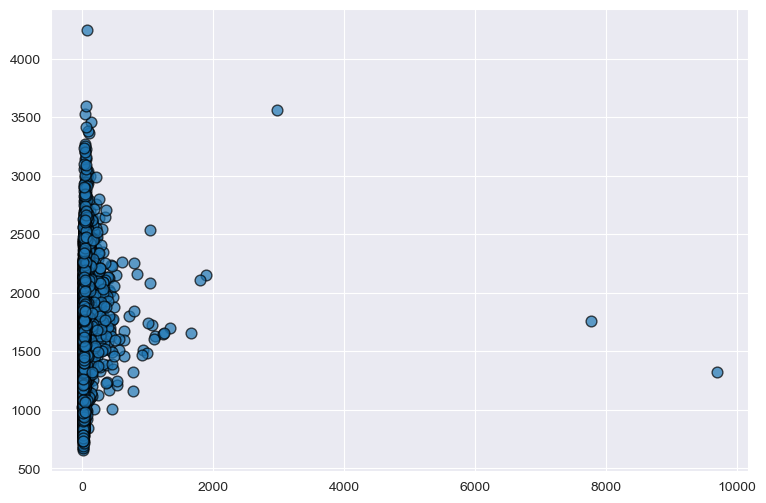

In [255]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(gdf_2_home['home_count'], gdf_2_home['Totalt'], s=60, alpha=0.7, edgecolors="k")



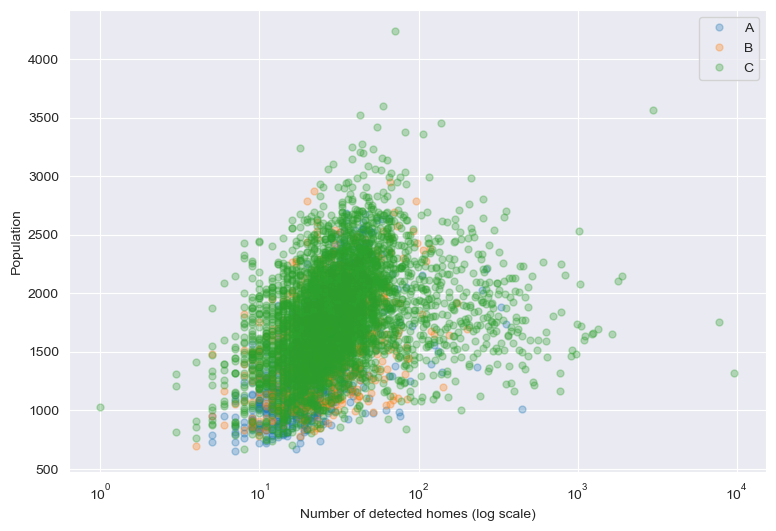

In [256]:
fig, ax = plt.subplots(figsize = (9, 6))

groups = gdf_2_home.groupby('urban_density')
for name, group in groups:
    ax.plot(group['home_count'], group['Totalt'], marker='o', linestyle='', alpha=0.3, markersize=5, label=name)
ax.set_xscale("log")
ax.set_xlabel("Number of detected homes (log scale)")
ax.set_ylabel("Population")

plt.legend()

plt.savefig("./figures/deso_pop_vs_detected_house_scatter.png")

In [262]:
gdf_2_home['home/pop'].quantile(0.95)

6.137038185205274

In [258]:
gdf_2_home = gdf_2_home[gdf_2_home["home/pop"]<100]


gdf_2_home_json = gdf_2_home[['Deso','geometry']].to_json()


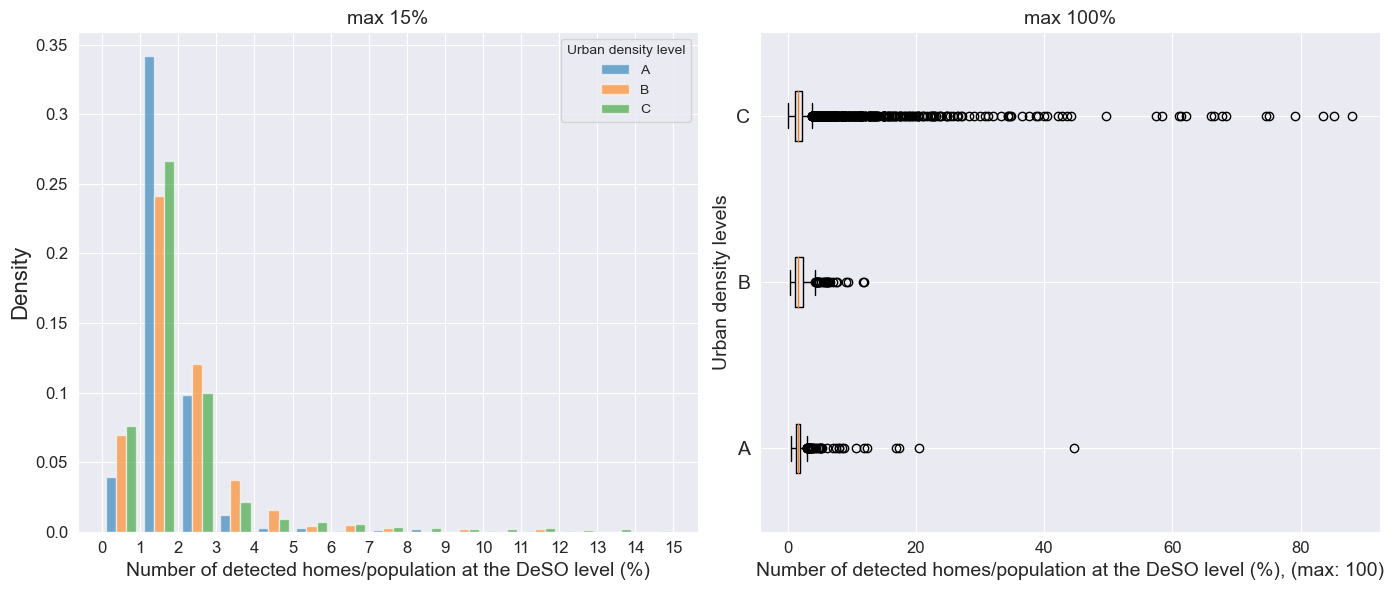

In [268]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (14, 6))

all_data = [gdf_2_home['home/pop'][gdf_2_home.urban_density== i] for i in ['A','B','C']]

ax0.hist(all_data, density=True, histtype='bar', label=['A','B','C'], alpha=0.6, bins=range(0,16,1))
ax0.legend(title= 'Urban density level', prop={'size': 10}, fontsize=14)
ax0.set_xlabel('Number of detected homes/population at the DeSO level (%)', fontsize=14)
ax0.set_title('max 15%', fontsize=14)
#ax0.set_xticklabels(np.arange(-6, 31, step=6), fontsize=12)
ax0.set_xticks(range(0,16,1),range(0,16,1), fontsize=12)
ax0.set_yticklabels(np.round(np.arange(0, 0.5, step=0.05),2), fontsize=12)
ax0.set_ylabel('Density', fontsize=16)


ax1.boxplot(all_data, vert=False)
ax1.set_title('max 100%', fontsize=14)
ax1.set_yticks([y + 1 for y in range(len(all_data))],
                  labels=['A', 'B', 'C'], fontsize=14)
#ax1.set_xticks([1,2,3,4,5,6],labels=[range(0,101,20)], fontsize=14)

ax1.set_xticklabels(range(-20,101,20), fontsize=12)
ax1.set_ylabel('Urban density levels', fontsize=14)
ax1.set_xlabel('Number of detected homes/population at the DeSO level (%), (max: 100)', fontsize=14)

#fig.suptitle('Detected homes vs population', fontsize=14)

fig.tight_layout()
plt.savefig("./figures/deso_pop_vs_detected_house_histogram.png")


In [22]:
import folium

m = folium.Map(location=[60, 15], zoom_start=5)

folium.Choropleth(
    geo_data=gdf_2_home_json,
    name="choropleth",
    data=gdf_2_home,
    columns=["Deso", "home/pop"],
    key_on='feature.properties.Deso',
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="The number of detected home / Population at DeSO (%)",
).add_to(m)

folium.LayerControl().add_to(m)

# Display the Choropleth
m.save('./figures/deso_pop_vs_detected_house.html')

## work detection evaluation by DeSO zones


In [234]:
gdf_2_work = gdf_2[gdf_2.work_potential== 1]

gdf_2_work= gdf_2_work.groupby('Deso')['uid'].count().reset_index().rename(columns={"uid":'work_count'})


In [235]:
gdf_2_work = pd.merge(DeSO, gdf_2_work, left_on=['Deso'], right_on=['Deso'], how="left")
gdf_2_work['work_count'] = gdf_2_work['work_count'].fillna(0).astype(int)

gdf_2_work['work/pop'] = gdf_2_work['work_count'] / gdf_2_work['Totalt'] * 100
gdf_2_work['urban_density'] = gdf_2_work['Deso'].str[4]



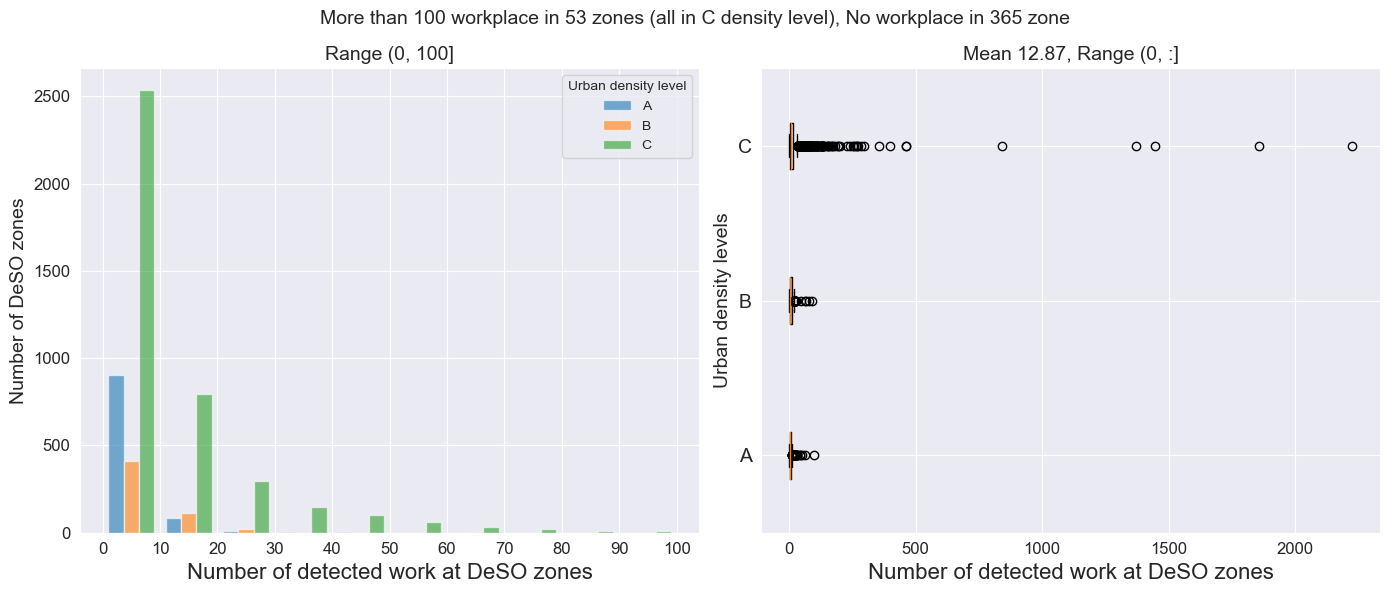

In [315]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (14, 6))

all_data = [gdf_2_work['work_count'][(gdf_2_work.urban_density== i)&(gdf_2_work['work_count']>0)] for i in ['A','B','C']]

ax0.hist(all_data, density=False, histtype='bar', label=['A','B','C'], alpha=0.6, bins=range(0,101,10))
ax0.legend(title= 'Urban density level', prop={'size': 10}, fontsize=14)
ax0.set_xlabel('Number of detected work at DeSO zones', fontsize=16)
ax0.set_title('Range (0, 100]', fontsize=14)
ax0.set_xticks(range(0,101,10),range(0,101,10), fontsize=12)
ax0.set_yticklabels(range(0, 2501, 500), fontsize=12)
ax0.set_ylabel('Number of DeSO zones', fontsize=14)


ax1.boxplot(all_data, vert=False)
ax1.set_title('Mean %s'%np.round(gdf_2_work['work_count'][(gdf_2_work.urban_density.isin(['A','B','C']))&(gdf_2_work['work_count']>0)].mean(),2)+', Range (0, :]', fontsize=14)
ax1.set_yticks([y + 1 for y in range(len(all_data))],
                   labels=['A', 'B', 'C'], fontsize=14)
# #ax1.set_xticks([1,2,3,4,5,6],labels=[range(0,101,20)], fontsize=14)
#
ax1.set_xticklabels(range(-500, 2501, 500), fontsize=12)
ax1.set_ylabel('Urban density levels', fontsize=14)
ax1.set_xlabel('Number of detected work at DeSO zones', fontsize=16)

fig.suptitle('More than 100 workplace in %s zones (all in C density level),'%len(gdf_2_work[(gdf_2_work.urban_density=='C')&(gdf_2_work['work_count']>100)])+' No workplace in %s zone'%len(gdf_2_work[gdf_2_work['work_count']<1])
, fontsize=14)
fig.tight_layout()
plt.savefig("./figures/deso_pop_vs_detected_work_histogram.png")


## commute distance

In [371]:
gdf_2_sweref = gdf_2.to_crs(3006, inplace=False)
#gdf_commute= gdf_2_sweref[gdf_2_sweref.work_potential== 1]

In [372]:
gdf_commute= gdf_2_sweref[gdf_2_sweref.uid.duplicated(keep=False)]

gdf_commute_first = gdf_commute[gdf_commute.uid.duplicated(keep='first')].set_index('uid')
gdf_commute_last = gdf_commute[gdf_commute.uid.duplicated(keep='last')].set_index('uid')


In [373]:
distances = gdf_commute_first.distance(gdf_commute_last, align=True).to_frame().reset_index()
distances.rename(columns={0:'distance(km)'}, inplace=True)
distances['distance(km)'] = distances['distance(km)']/1000

In [374]:
individual = gdf_commute[(gdf_commute['uid']=='6626de3e-1efd-4ea2-9900-eb02d2af6231')]


In [377]:
len(distances['distance(km)'][distances['distance(km)']>500])

1277

{'bodies': [<matplotlib.collections.PolyCollection at 0x2421f6dc4c8>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x2423f564848>,
 'cmins': <matplotlib.collections.LineCollection at 0x242a59afc88>,
 'cbars': <matplotlib.collections.LineCollection at 0x24201de5588>}

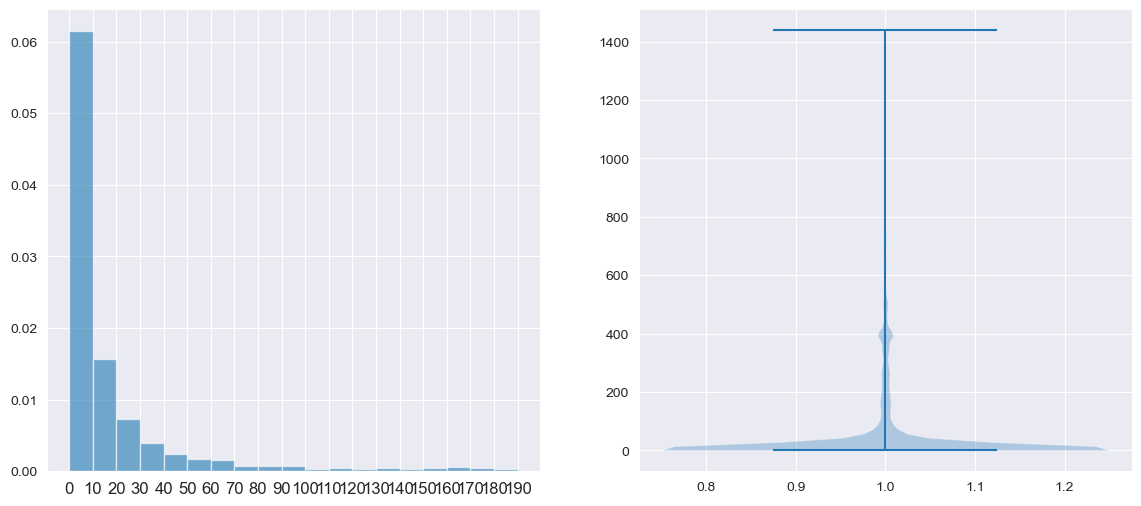

In [389]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (14, 6))


ax0.hist(distances['distance(km)'][distances['distance(km)']<300], density=True, histtype='bar', alpha=0.6, bins=range(0,200,10))
# ax0.legend(title= 'Urban density level', prop={'size': 10}, fontsize=14)
# ax0.set_xlabel('Number of detected work at DeSO zones', fontsize=16)
# ax0.set_title('Range (0, 100]', fontsize=14)
ax0.set_xticks(range(0,200,10),range(0,200,10), fontsize=12)
# ax0.set_yticklabels(range(0, 2501, 500), fontsize=12)
# ax0.set_ylabel('Number of DeSO zones', fontsize=14)


ax1.violinplot(distances['distance(km)'], vert=True)
# ax1.set_title('Mean %s'%np.round(gdf_2_work['work_count'][(gdf_2_work.urban_density.isin(['A','B','C']))&(gdf_2_work['work_count']>0)].mean(),2)+', Range (0, :]', fontsize=14)
# ax1.set_yticks([y + 1 for y in range(len(all_data))],
#                    labels=['A', 'B', 'C'], fontsize=14)
# # #ax1.set_xticks([1,2,3,4,5,6],labels=[range(0,101,20)], fontsize=14)
# #
# ax1.set_xticklabels(range(-500, 2501, 500), fontsize=12)
# ax1.set_ylabel('Urban density levels', fontsize=14)
# ax1.set_xlabel('Number of detected work at DeSO zones', fontsize=16)
#
# fig.suptitle('More than 100 workplace in %s zones (all in C density level),'%len(gdf_2_work[(gdf_2_work.urban_density=='C')&(gdf_2_work['work_count']>100)])+' No workplace in %s zone'%len(gdf_2_work[gdf_2_work['work_count']<1])
# , fontsize=14)
# fig.tight_layout()
# plt.savefig("./figures/deso_pop_vs_detected_work_histogram.png")
